# Developmental file for modifying the 1D advection solver to work for multiple wave equations

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))

import numpy as np
from matplotlib import pyplot as plt
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import lagrange
from dg_maxwell import wave_equation as w1d
from dg_maxwell import utils

af.set_backend('opencl')
af.set_device(1)
af.info()

plt.rcParams['figure.figsize']     = 12, 7.5
plt.rcParams['lines.linewidth']    = 1.5
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.weight']        = 'bold'
plt.rcParams['font.size']          = 20  
plt.rcParams['font.sans-serif']    = 'serif'
plt.rcParams['text.usetex']        = True
plt.rcParams['axes.linewidth']     = 1.5
plt.rcParams['axes.titlesize']     = 'medium'
plt.rcParams['axes.labelsize']     = 'medium'

plt.rcParams['xtick.major.size']   = 8
plt.rcParams['xtick.minor.size']   = 4
plt.rcParams['xtick.major.pad']    = 8
plt.rcParams['xtick.minor.pad']    = 8
plt.rcParams['xtick.color']        = 'k'
plt.rcParams['xtick.labelsize']    = 'medium'
plt.rcParams['xtick.direction']    = 'in'    

plt.rcParams['ytick.major.size']   = 8
plt.rcParams['ytick.minor.size']   = 4
plt.rcParams['ytick.major.pad']    = 8
plt.rcParams['ytick.minor.pad']    = 8
plt.rcParams['ytick.color']        = 'k'
plt.rcParams['ytick.labelsize']    = 'medium'
plt.rcParams['ytick.direction']    = 'in'
plt.rcParams['text.usetex']        = True
plt.rcParams['text.latex.unicode'] = True

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [2]:
# 1. Set the initial conditions

E_00 = 1.
E_01 = 1.

B_00 = 0.2
B_01 = 0.5

E_z_init = E_00 * af.sin(2 * np.pi * params.element_LGL) \
         + E_01 * af.cos(2 * np.pi * params.element_LGL)

B_y_init = B_00 * af.sin(2 * np.pi * params.element_LGL) \
         + B_01 * af.cos(2 * np.pi * params.element_LGL)

u_init = af.constant(0., d0 = params.N_LGL, d1 = params.N_Elements, d2 = 2, dtype = af.Dtype.f64)
u_init[:, :, 0] = E_z_init
u_init[:, :, 1] = E_z_init

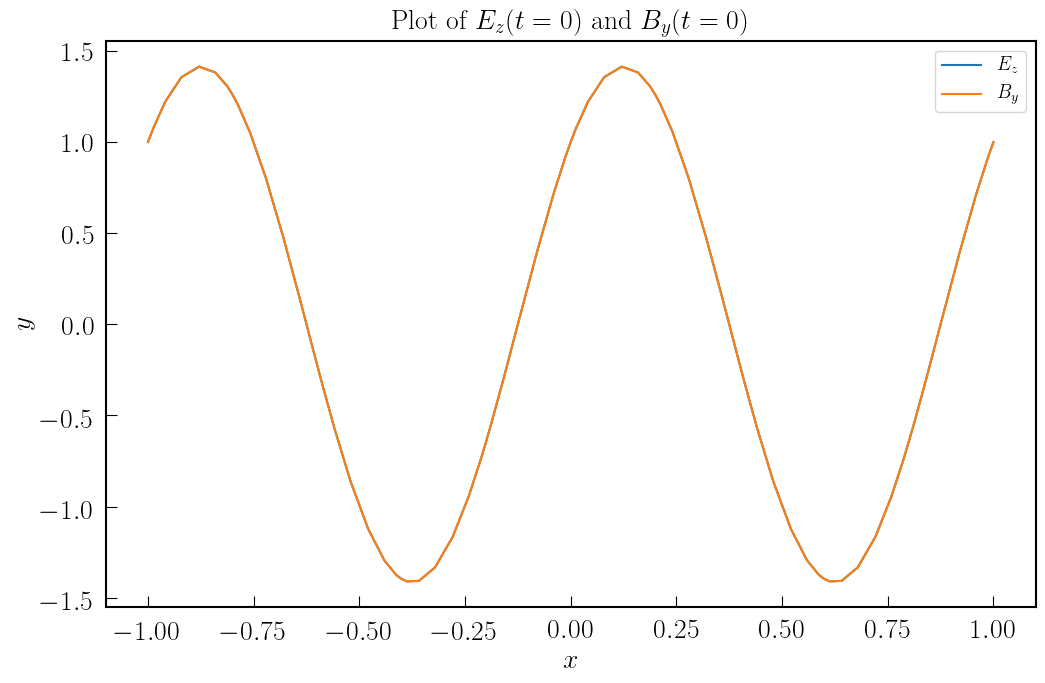

In [3]:
element_LGL_flat = af.flat(params.element_LGL)
E_z_init_flat    = af.flat(u_init[:, :, 0])
B_y_init_flat    = af.flat(u_init[:, :, 1])

plt.plot(element_LGL_flat, E_z_init_flat, label = r'$E_z$')
plt.plot(element_LGL_flat, B_y_init_flat, label = r'$B_y$')

plt.title(r'Plot of $E_z(t = 0)$ and $B_y(t = 0)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.legend(prop={'size': 14})

plt.show()

# Prototype implementation of surface term for multiple-u's

In [3]:
u_n = u_init[:, :, 0]
# Older surface term code.

L_p_minus1   = params.lagrange_basis_value[:, 0]
L_p_1        = params.lagrange_basis_value[:, -1]
f_i          = w1d.lax_friedrichs_flux(u_n)
f_iminus1    = af.shift(f_i, 0, 1)
surface_term = af.blas.matmul(L_p_1, f_i) - af.blas.matmul(L_p_minus1,\
                                                                f_iminus1)
surface_term_ref = surface_term.copy()
print(surface_term_ref.shape)

(8, 10)


# Code refactor of the old surface term code to handle multilple u

In [3]:
# Arguments
u_n = u_init[:, :, :]

#####################################################
######################CODE###########################
#####################################################

shape_u_n = utils.shape(u_n)

L_p_minus1   = af.tile(params.lagrange_basis_value[:, 0],
                       d0 = 1, d1 = 1, d2 = shape_u_n[2])
L_p_1        = af.tile(params.lagrange_basis_value[:, -1],
                       d0 = 1, d1 = 1, d2 = shape_u_n[2])
f_i          = w1d.lax_friedrichs_flux(u_n)
f_iminus1    = af.shift(f_i, 0, 1)

surface_term = utils.matmul_3D(L_p_1, f_i) \
             - utils.matmul_3D(L_p_minus1, f_iminus1)

print(surface_term.shape)
surface_term_test = surface_term.copy()

(8, 10, 2)


# Testing

In [5]:
print(af.all_true(af.abs(w1d.surface_term_multiple_u(u_n)[:, :, 1] - w1d.surface_term(u_n[:, :, 0])) < 1e-14))

1.0
